<a href="https://colab.research.google.com/github/Mafaz03/Autoencoder/blob/main/15_DDPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torcheval datasets diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00


In [ ]:
import requests
import os

os.makedirs("miniai", exist_ok=True)

def import_python_files_from_github(urls, local_filenames):
    if len(urls) != len(local_filenames):
        print("Number of URLs and local filenames must be equal.")
        return False

    success = True
    for url, filename in zip(urls, local_filenames):
        response = requests.get(url)
        if response.status_code == 200:
            with open(os.path.join("miniai", filename), 'wb') as f:
                f.write(response.content)
        else:
            print(f'Failed to fetch file from GitHub: {url}')
            success = False

    return success

local_filenames = ['datasets.py', 'conv.py', 'training.py', 'learner.py', 'activations.py', 'init.py', 'sgd.py', 'resnet.py', 'augment.py']
github_url = "https://raw.githubusercontent.com/fastai/course22p2/master/miniai/"
github_urls = [github_url + file for file in local_filenames]

success = import_python_files_from_github(github_urls, local_filenames)




In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

In [ ]:
from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.init import *

In [ ]:
from diffusers import UNet2DModel

In [ ]:
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 128))

In [ ]:
mpl.rcParams['image.cmap'] = 'gray'
logging.disable(logging.WARNING)

In [ ]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
@inplace
def transformi(b): b[x] = [TF.resize(TF.to_tensor(o), (32,32)) for o in b[x]]

In [ ]:
set_seed(42)
bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(torch.Size([128, 1, 32, 32]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

In [ ]:
lol = list(dt)

In [ ]:
firstbatch = lol[0][0]

In [ ]:
firstbatch.shape

torch.Size([128, 1, 32, 32])

In [ ]:
random_noise = torch.randn(firstbatch.shape)

In [ ]:
random_noise.shape

torch.Size([128, 1, 32, 32])

In [ ]:
image_with_noise = firstbatch * random_noise
image_with_noise.shape

torch.Size([128, 1, 32, 32])

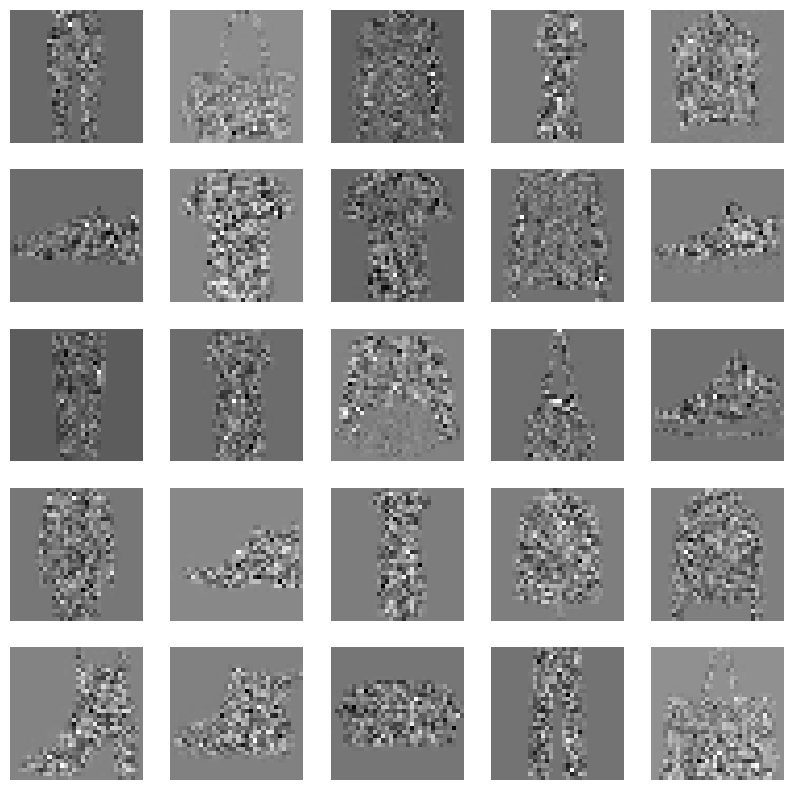

In [ ]:
show_images(image_with_noise[:25], 5, 5, figsize=(10,10))

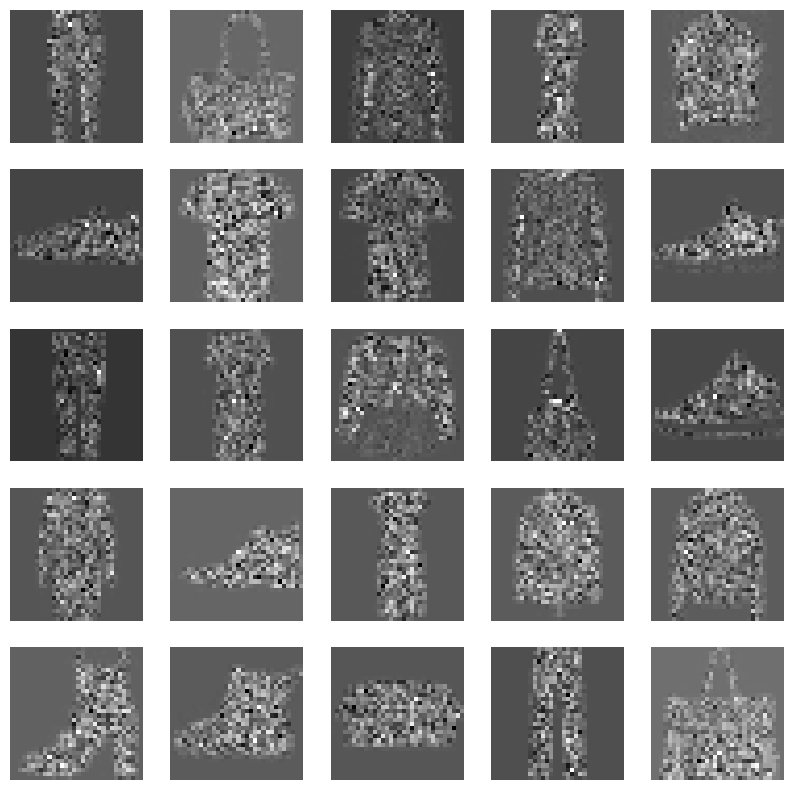

In [ ]:
image_with_noise = (firstbatch) * (0.8 + random_noise)
show_images(image_with_noise[:25], 5, 5, figsize=(10,10))

In [ ]:
β = torch.linspace(0.0001, 0.02, 1000)
α = 1. - β
ᾱ = torch.cumprod(α, dim=0)
σ = β.sqrt()

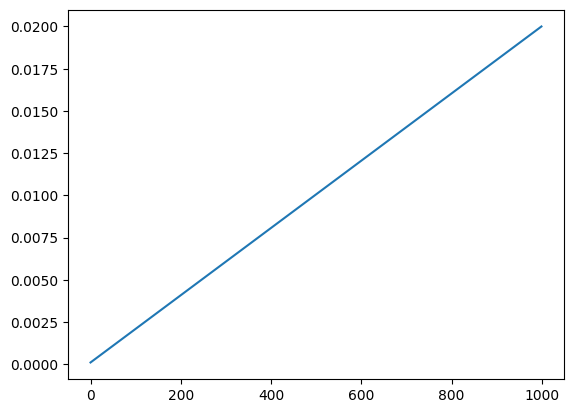

In [ ]:
plt.plot(β)

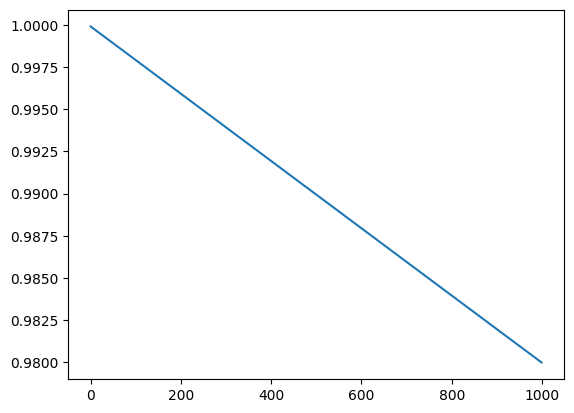

In [ ]:
plt.plot(α)

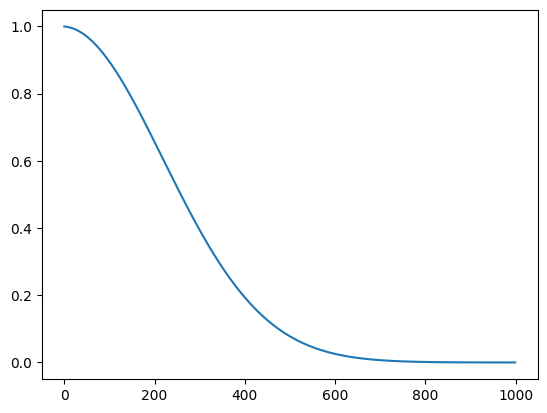

In [ ]:
plt.plot(ᾱ)

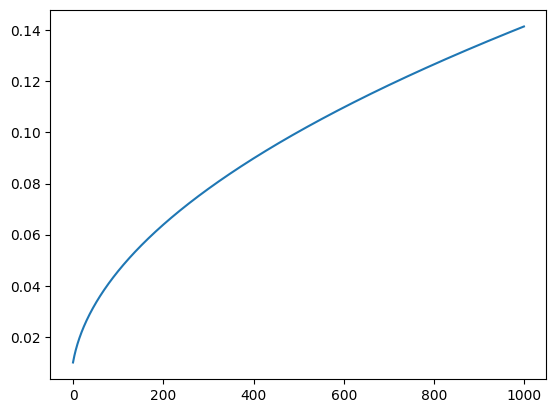

In [ ]:
plt.plot(σ)

In [ ]:
n = firstbatch.shape[0]
n

128

In [ ]:
t = torch.randint(0, 1000, (n,), dtype=torch.long)
t

tensor([236, 607,  27, 696, 979, 835, 479, 830, 819, 568, 513, 212, 596, 585,
        683, 913, 421, 866, 538,  16, 264, 874, 861, 997, 857, 615, 630, 959,
        645, 647, 408, 286, 497, 352, 743, 252, 561, 682, 474, 941, 734, 992,
        801, 499, 118,  95, 986, 346, 337, 721,  72, 703, 655, 349, 389, 339,
        687, 686, 706, 161,  47, 202,  94, 111, 659, 925, 807, 949, 502, 380,
        404, 691, 657,  52, 486, 926,  41, 776, 594, 958, 719, 904, 239, 366,
        366,   4, 732, 665, 428, 657, 739, 372,  27, 515, 189, 802,  53, 105,
        819, 714, 172, 844, 891, 885, 444, 185, 710, 484, 896, 660, 811, 490,
        985, 417, 450, 137, 671, 701, 971, 307, 954, 731, 296, 611, 137, 394,
        189, 920])

In [ ]:
ᾱ[t]

tensor([5.5894e-01, 2.3474e-02, 9.8972e-01, 7.2672e-03, 6.0219e-05, 8.4527e-04,
        9.5794e-02, 9.1950e-04, 1.1046e-03, 3.7312e-02, 6.8090e-02, 6.2392e-01,
        2.6835e-02, 3.0603e-02, 8.7112e-03, 2.1293e-04, 1.6254e-01, 4.9596e-04,
        5.2194e-02, 9.9560e-01, 4.8452e-01, 4.3084e-04, 5.4121e-04, 4.2022e-05,
        5.8015e-04, 2.1264e-02, 1.7605e-02, 8.9126e-05, 1.4510e-02, 1.4135e-02,
        1.8129e-01, 4.2832e-01, 8.0188e-02, 2.7917e-01, 3.6679e-03, 5.1611e-01,
        4.0418e-02, 8.8322e-03, 1.0053e-01, 1.2596e-04, 4.1955e-03, 4.6469e-05,
        1.4833e-03, 7.8587e-02, 8.5909e-01, 9.0438e-01, 5.2397e-05, 2.9130e-01,
        3.1007e-01, 5.0796e-03, 9.4207e-01, 6.5822e-03, 1.2723e-02, 2.8520e-01,
        2.1138e-01, 3.0584e-01, 8.2417e-03, 8.3569e-03, 6.3068e-03, 7.5860e-01,
        9.7309e-01, 6.5096e-01, 9.0619e-01, 8.7360e-01, 1.2064e-02, 1.7036e-04,
        1.3455e-03, 1.0810e-04, 7.6235e-02, 2.2675e-01, 1.8736e-01, 7.7950e-03,
        1.2389e-02, 9.6777e-01, 8.9463e-

In [ ]:
ᾱ[t].max(), ᾱ[t].min()

(tensor(0.9993), tensor(4.2022e-05))

In [ ]:
ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1)
ᾱ_t.shape

torch.Size([128, 1, 1, 1])

In [ ]:
xt = ᾱ_t.sqrt()*firstbatch + (1-ᾱ_t).sqrt()*random_noise
xt.shape

torch.Size([128, 1, 32, 32])

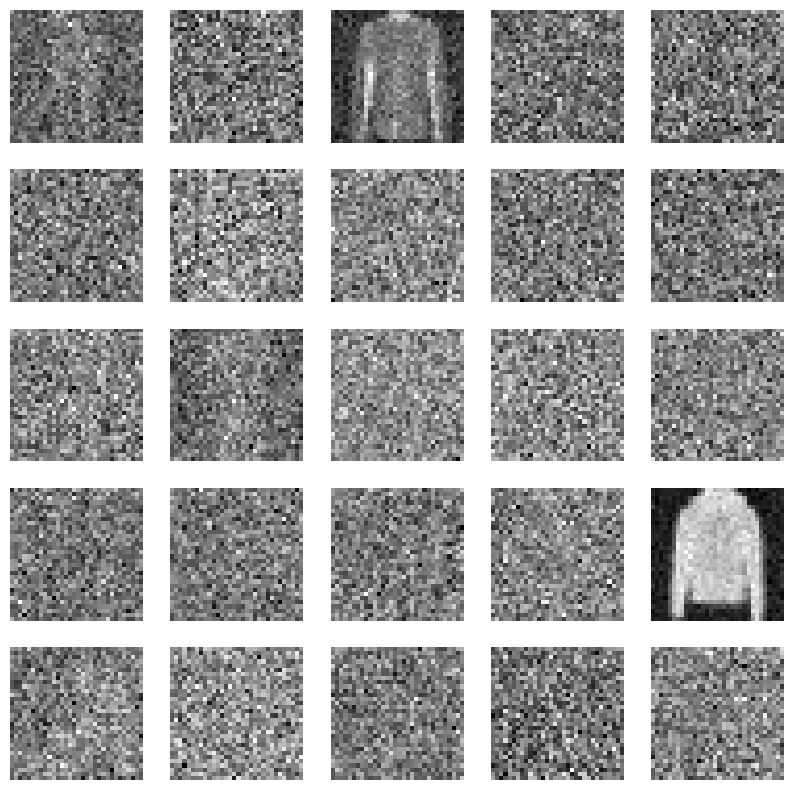

In [ ]:
show_images(xt[:25], 5, 5, figsize=(10,10))

In [ ]:
def noisify(x0, ᾱ):
  ε = torch.randn(x0.shape)
  n = x0.shape[0]
  t = torch.randint(0, 1000, (n,), dtype=torch.long)
  ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1)
  xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
  return xt

torch.Size([128, 1, 32, 32])


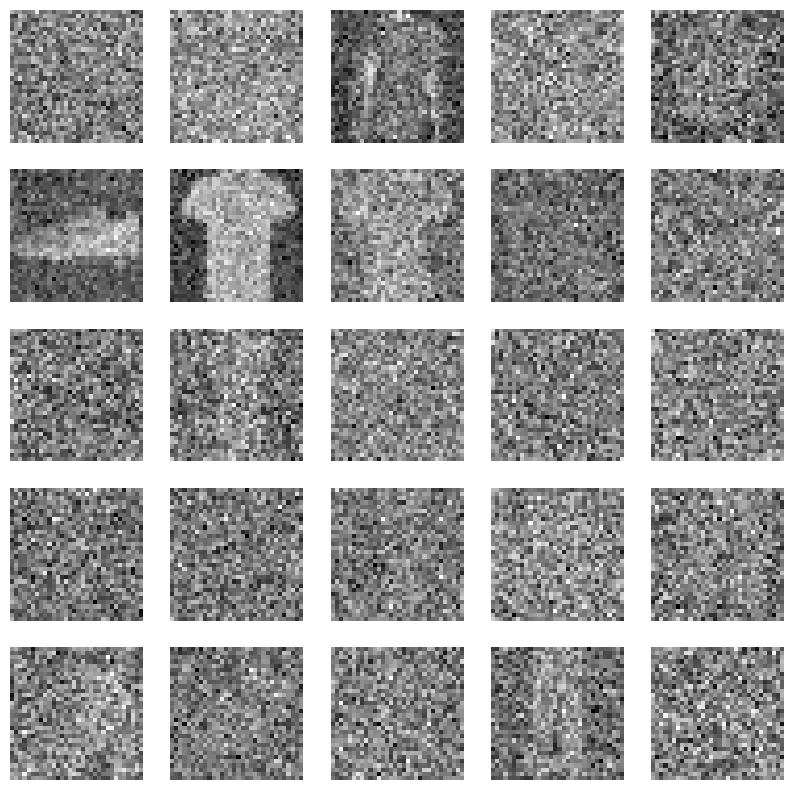

In [ ]:
noisify_batch = noisify(firstbatch, ᾱ)
print(noisify_batch.shape)
show_images(noisify_batch[:25], 5, 5, figsize=(10,10))

In [ ]:
t.shape

torch.Size([128])

Sampling

In [ ]:
x_t = torch.randn(noisify_batch.shape)
x_t.shape

torch.Size([128, 1, 32, 32])

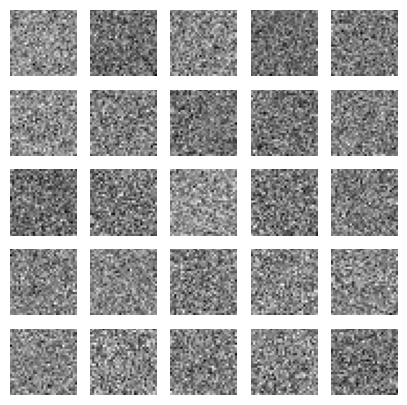

In [ ]:
show_images(x_t[:25], 5, 5, figsize=(5,5))

In [ ]:
x_t.shape[0]

128

In [ ]:
(x_t.shape[0],)

(128,)

In [ ]:
import numpy as np

# Convert tensor t to a numpy array and extract a single value
fill_value = np.array(t)[0]
fill_value

236

In [ ]:
x_t.shape

torch.Size([128, 1, 32, 32])

In [ ]:
t_batch = torch.full((x_t.shape[0],), 1000, dtype=torch.long)
t_batch

tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])

In [ ]:
t_batch.shape

torch.Size([128])

In [ ]:
pred = model(x_t, t_batch)

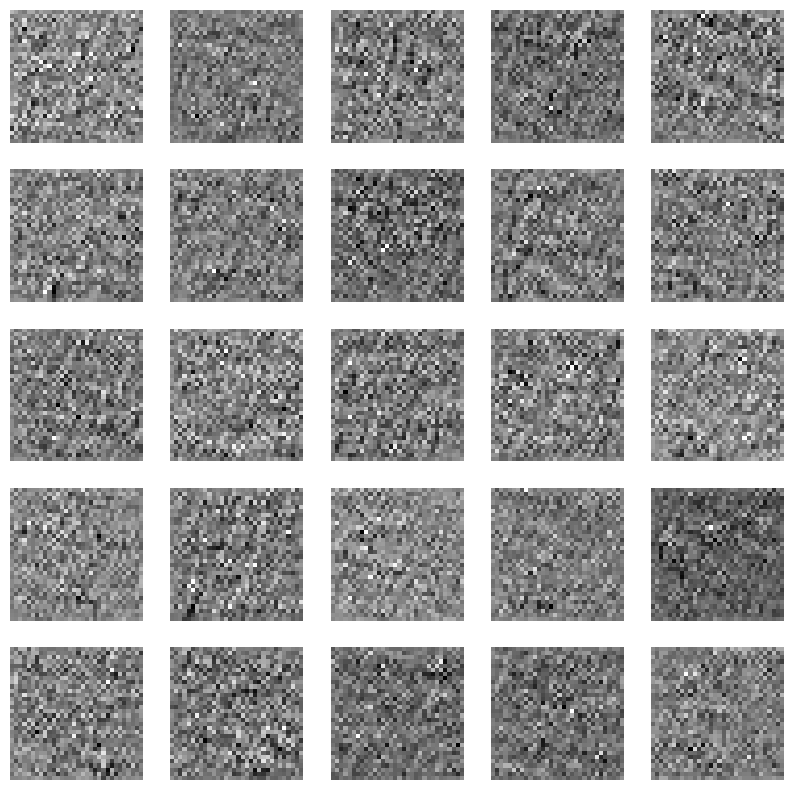

In [ ]:
show_images(pred[0][:25], 5, 5, figsize=(10,10))

In [ ]:
one_step_denoised_image = x_t - pred[0]

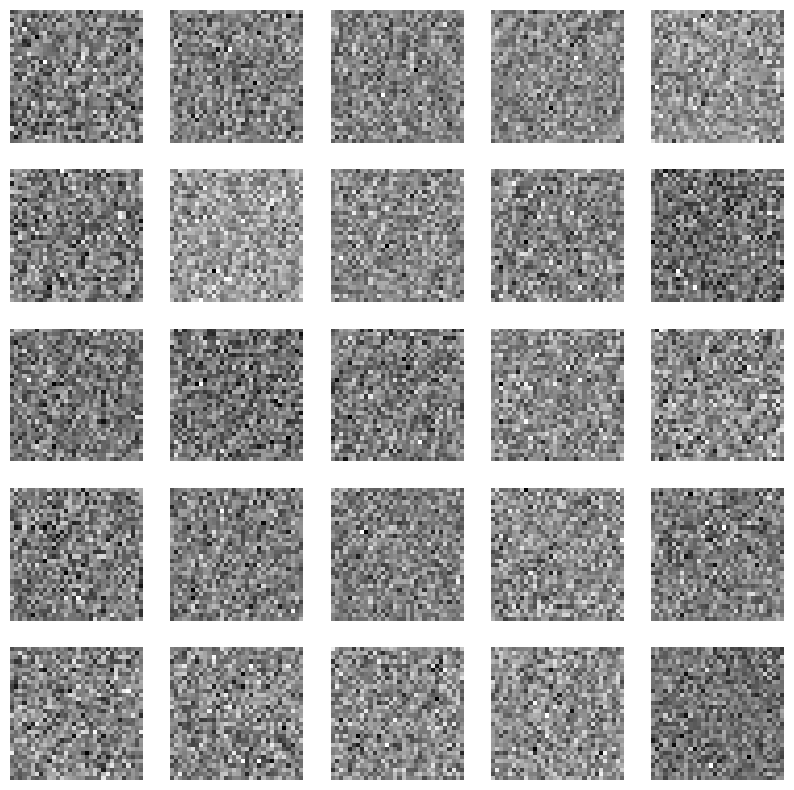

In [ ]:
show_images(one_step_denoised_image[:25], 5, 5, figsize=(10,10))

In [ ]:
time_step = 700

In [ ]:
ᾱ_t1 = ᾱ[time_step-1]
b̄_t = 1 - ᾱ[time_step]
b̄_t1 = 1 - ᾱ_t1

In [ ]:
x_0_hat = ((x_t - (b̄_t.sqrt() * pred[0]))/ᾱ[time_step].sqrt()).clamp(-1,1)
z = (torch.randn(x_t.shape))
x0_coeff = ᾱ_t1.sqrt()*(1-α[time_step])/b̄_t
xt_coeff = α[time_step].sqrt()*b̄_t1/b̄_t
x_t = x_0_hat*x0_coeff + x_t*xt_coeff + σ[time_step]*z

In [ ]:
x_t.shape

torch.Size([128, 1, 32, 32])

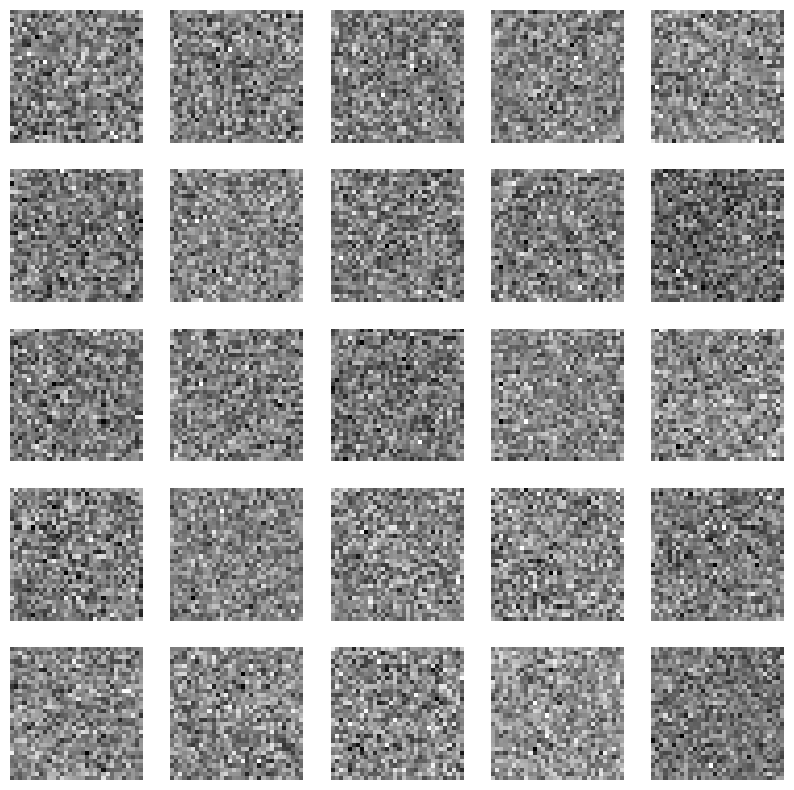

In [ ]:
show_images(x_t[:25], 5, 5, figsize=(10,10))

In [ ]:
preds_global = []
def sample(model, sz, time_step, α, ᾱ, sigma):
  ᾱ_t1 = ᾱ[time_step-1]
  b̄_t = 1 - ᾱ[time_step]
  b̄_t1 = 1 - ᾱ_t1
  preds = []
  x_t = torch.randn(sz)

  for t in reversed(range(time_step)):

    t_batch = torch.full((x_t.shape[0],), t, dtype=torch.long)
    x_0_hat = ((x_t - (b̄_t.sqrt() * model(x_t, t_batch)[0]))/ᾱ[time_step].sqrt()).clamp(-1,1)

    z = (torch.randn(x_t.shape))
    x0_coeff = ᾱ_t1.sqrt()*(1-α[time_step])/b̄_t
    xt_coeff = α[time_step].sqrt()*b̄_t1/b̄_t
    x_t = x_0_hat*x0_coeff + x_t*xt_coeff + σ[time_step]*z
    preds.append(x_t.cpu())
    preds_global.append(x_t.cpu())
  return preds

In [ ]:
samples = sample(model, noisify_batch.shape, 1, α, ᾱ, σ)

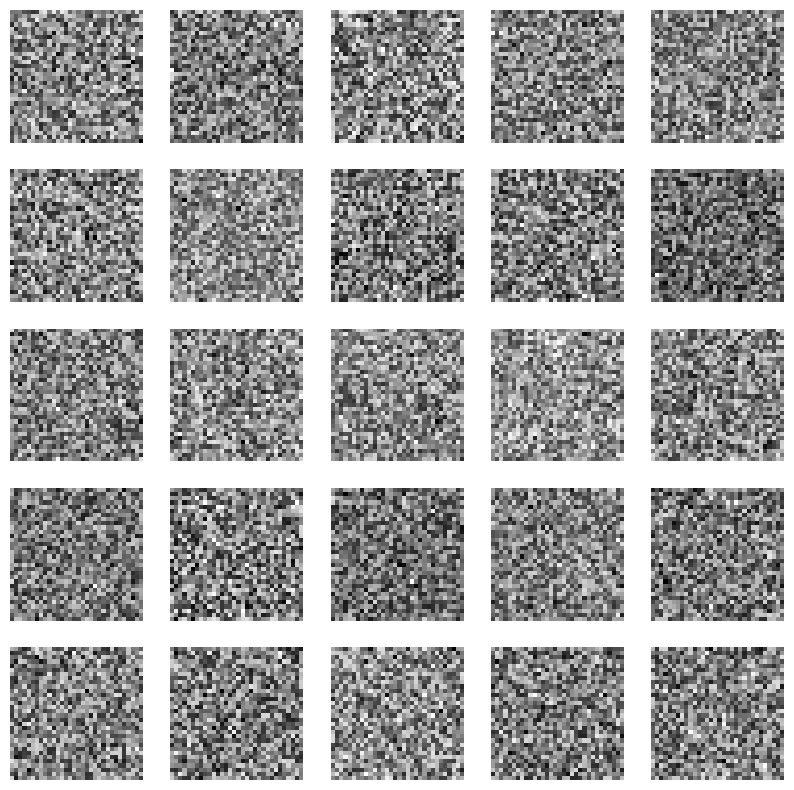

In [ ]:
show_images(preds_global[0][:25], 5, 5, figsize=(10,10))

In [ ]:
plt.imshow(xb[0].permute(1,2,0))#.shape

In [ ]:
import torch

# Assuming xb[0] is a torch.Tensor of shape (C, H, W), where C is the number of channels, H is the height, and W is the width.
tensor = xb[0].permute(1, 2, 0)  # Permute dimensions to (H, W, C)

# Calculate mean and standard deviation along each channel
mean = tensor.mean(dim=(0, 1))
std = tensor.std(dim=(0, 1))

# Normalize the tensor
normalized_tensor = (tensor - mean) / std

In [ ]:
plt.imshow(normalized_tensor)

In [ ]:
class DDPMCB(TrainCB):
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        self.n_steps,self.βmin,self.βmax = n_steps,beta_min,beta_max
        # variance schedule, linearly increased with timestep
        self.β = torch.linspace(self.βmin, self.βmax, self.n_steps)
        self.α = 1. - self.β
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.β.sqrt()

    def predict(self, learn): learn.preds = learn.model(*learn.batch[0]).sample

    def before_batch(self, learn):
        device = learn.batch[0].device
        ε = torch.randn(learn.batch[0].shape, device=device)  # noise, x_T
        x0 = learn.batch[0] # original images, x_0
        self.ᾱ = self.ᾱ.to(device)
        n = x0.shape[0]
        # select random timesteps
        t = torch.randint(0, self.n_steps, (n,), device=device, dtype=torch.long)
        ᾱ_t = self.ᾱ[t].reshape(-1, 1, 1, 1).to(device)
        xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε #noisify the image
        # input to our model is noisy image and timestep, ground truth is the noise
        learn.batch = ((xt, t), ε)

    @torch.no_grad()
    def sample(self, model, sz):
        device = next(model.parameters()).device
        x_t = torch.randn(sz, device=device)
        preds = []
        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
            z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
            ᾱ_t1 = self.ᾱ[t-1]  if t > 0 else torch.tensor(1)
            b̄_t = 1 - self.ᾱ[t]
            b̄_t1 = 1 - ᾱ_t1
            noise_pred = learn.model(x_t, t_batch).sample
            x_0_hat = ((x_t - b̄_t.sqrt() * noise_pred)/self.ᾱ[t].sqrt()).clamp(-1,1)
            x0_coeff = ᾱ_t1.sqrt()*(1-self.α[t])/b̄_t
            xt_coeff = self.α[t].sqrt()*b̄_t1/b̄_t
            x_t = x_0_hat*x0_coeff + x_t*xt_coeff + self.σ[t]*z
            preds.append(x_t.cpu())
        return preds

In [ ]:
lr = 4e-3
epochs = 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=optim.Adam)

In [ ]:
learn.fit(epochs)

In [ ]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)

In [ ]:
torch.save(learn.model, mdl_path/'fashion_ddpm.pkl')

In [ ]:
learn.model = torch.load(mdl_path/'fashion_ddpm.pkl')

In [ ]:
set_seed(42)
samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32))
len(samples)

In [ ]:
show_images(-samples[-1], figsize=(5,5))